# Multiclass classification using a neural network

Here we adopt a 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold

Using TensorFlow backend.


In [2]:
matrix = pd.read_csv('model/1129-fixed-data-matrix-karlgren.csv').set_index('character')

In [3]:
cols = matrix.columns
features_cols = [c for c in cols if 'Karlgren' not in c and 'tone_label' not in c]
labels_cols = [c for c in cols if c not in features_cols]

In [182]:
X_complete = matrix[features_cols]
Y_complete = matrix[labels_cols]
X_train, X_test, Y_train, Y_test = train_test_split(X_complete, Y_complete, test_size=.3, random_state=0)

In [183]:
label_categories = [
    'tone_label',
    'Karlgren_onset',
    'Karlgren_nucleus',
    'Karlgren_coda'
]

In [188]:
def fit_keras_models(X, X_test, Y, Y_test, architecture, n_epochs=200, n_folds=5):
    category_to_performance = defaultdict(list)
    category_to_test_performance = defaultdict(list)
    category_to_callbacks = defaultdict(list)
    
    for category in label_categories:
        Y_subset = Y[[x for x in Y.columns if category in x]]
        Y_test_subset = Y_test[[x for x in Y_test.columns if category in x]]
        n_bins = Y_subset.shape[1]
        
        def build_keras_nn_model():
            model = Sequential()
            model.add(Dense(
                architecture[0][0],
                input_dim=X.shape[1],
                activation=architecture[0][1])
            )
            
            if len(architecture) > 1:
                for l, (hidden_layer_size, act_fn) in enumerate(architecture[1:]):
                    model.add(Dense(
                        hidden_layer_size,
                        input_dim=architecture[l - 1],
                        activation=act_fn)
                    )
                    
            model.add(Dense(n_bins, activation='softmax'))
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            return model
        
        KerasNN = KerasClassifier(
            build_fn=build_keras_nn_model,
            epochs=n_epochs,
            batch_size=256,
            verbose=True
        )
        
        kf = KFold(n_splits=n_folds, random_state=0, shuffle=False)
        for kf_idx, (train_idx, dev_idx) in enumerate(kf.split(X)):
            X_train, X_dev = X.iloc[train_idx], X.iloc[dev_idx]
            Y_train, Y_dev = Y_subset.iloc[train_idx], Y_subset.iloc[dev_idx]
            
            hist_callback = KerasNN.fit(
                X_train,
                Y_train,
                validation_data=(X_dev, Y_dev)
            )
            
            category_to_callbacks[category].append(hist_callback)
            dev_score = KerasNN.score(X_dev, Y_dev)
            category_to_performance[category].append(dev_score)
            test_acc = KerasNN.score(X_test, Y_test_subset)
            category_to_test_performance[category].append(test_acc)
            print('Category: {:16s}\tCV: {} of {}\tDev performance: {:.3f}'.format(
                category, kf_idx + 1, n_folds, float(dev_score)))
    return category_to_performance, category_to_callbacks, category_to_test_performance

In [189]:
N_EPOCHS = 15
N_FOLDS = 5
ARCHITECTURE = [
    (32, 'relu'),
    (32, 'relu'),
    (32, 'relu')
]

performance, callbacks, test_performance = fit_keras_models(
    X_train,
    X_test,
    Y_train,
    Y_test,
    architecture=ARCHITECTURE,
    n_epochs=N_EPOCHS,
    n_folds=N_FOLDS
)

Train on 8540 samples, validate on 2135 samples
Epoch 1/15
8540/8540 [==============================] - 16s 2ms/step - loss: 1.3048 - acc: 0.3961 - val_loss: 1.1696 - val_acc: 0.4525
Epoch 2/15
8540/8540 [==============================] - 0s 48us/step - loss: 1.0066 - acc: 0.5516 - val_loss: 0.7801 - val_acc: 0.7208
Epoch 3/15
8540/8540 [==============================] - 0s 50us/step - loss: 0.6353 - acc: 0.7767 - val_loss: 0.5661 - val_acc: 0.7963
Epoch 4/15
8540/8540 [==============================] - 0s 52us/step - loss: 0.5450 - acc: 0.7985 - val_loss: 0.5520 - val_acc: 0.8000
Epoch 5/15
8540/8540 [==============================] - 0s 49us/step - loss: 0.5250 - acc: 0.8040 - val_loss: 0.5483 - val_acc: 0.8023
Epoch 6/15
8540/8540 [==============================] - 0s 51us/step - loss: 0.5103 - acc: 0.8102 - val_loss: 0.5478 - val_acc: 0.8037
Epoch 7/15
8540/8540 [==============================] - 0s 49us/step - loss: 0.5024 - acc: 0.8104 - val_loss: 0.5508 - val_acc: 0.8042
Epoch 8

8540/8540 [==============================] - 0s 48us/step - loss: 0.4727 - acc: 0.8193 - val_loss: 0.5514 - val_acc: 0.8037
Epoch 12/15
8540/8540 [==============================] - 0s 46us/step - loss: 0.4673 - acc: 0.8194 - val_loss: 0.5550 - val_acc: 0.8014
Epoch 13/15
8540/8540 [==============================] - 0s 51us/step - loss: 0.4616 - acc: 0.8218 - val_loss: 0.5576 - val_acc: 0.8023
Epoch 14/15
8540/8540 [==============================] - 0s 49us/step - loss: 0.4567 - acc: 0.8240 - val_loss: 0.5637 - val_acc: 0.8005
Epoch 15/15
4575/4575 [==============================] - 0s 27us/step
Category: tone_label      	CV: 4 of 5	Dev performance: 0.803
Train on 8540 samples, validate on 2135 samples
Epoch 1/15
8540/8540 [==============================] - 16s 2ms/step - loss: 1.2633 - acc: 0.4242 - val_loss: 1.0851 - val_acc: 0.5194
Epoch 2/15
8540/8540 [==============================] - 0s 49us/step - loss: 0.8989 - acc: 0.6260 - val_loss: 0.7115 - val_acc: 0.7237
Epoch 3/15
8540/854

Epoch 5/15
8540/8540 [==============================] - 0s 53us/step - loss: 1.4911 - acc: 0.5876 - val_loss: 1.4875 - val_acc: 0.5714
Epoch 6/15
8540/8540 [==============================] - 0s 52us/step - loss: 1.3085 - acc: 0.6254 - val_loss: 1.3813 - val_acc: 0.5925
Epoch 7/15
8540/8540 [==============================] - 0s 52us/step - loss: 1.2034 - acc: 0.6557 - val_loss: 1.3153 - val_acc: 0.6141
Epoch 8/15
8540/8540 [==============================] - 0s 52us/step - loss: 1.1338 - acc: 0.6739 - val_loss: 1.2677 - val_acc: 0.6417
Epoch 9/15
8540/8540 [==============================] - 0s 54us/step - loss: 1.0807 - acc: 0.6917 - val_loss: 1.2390 - val_acc: 0.6492
Epoch 10/15
8540/8540 [==============================] - 0s 55us/step - loss: 1.0353 - acc: 0.7075 - val_loss: 1.2192 - val_acc: 0.6511
Epoch 11/15
8540/8540 [==============================] - 1s 67us/step - loss: 0.9995 - acc: 0.7164 - val_loss: 1.2055 - val_acc: 0.6614
Epoch 12/15
8540/8540 [==============================

4575/4575 [==============================] - 0s 29us/step
Category: Karlgren_nucleus	CV: 1 of 5	Dev performance: 0.624
Train on 8540 samples, validate on 2135 samples
Epoch 1/15
8540/8540 [==============================] - 16s 2ms/step - loss: 3.9897 - acc: 0.0811 - val_loss: 3.8224 - val_acc: 0.0867
Epoch 2/15
8540/8540 [==============================] - 0s 58us/step - loss: 3.5536 - acc: 0.1183 - val_loss: 3.3856 - val_acc: 0.1630
Epoch 3/15
8540/8540 [==============================] - 0s 57us/step - loss: 3.0589 - acc: 0.2071 - val_loss: 2.8607 - val_acc: 0.2585
Epoch 4/15
8540/8540 [==============================] - 0s 56us/step - loss: 2.5124 - acc: 0.3641 - val_loss: 2.3576 - val_acc: 0.4234
Epoch 5/15
8540/8540 [==============================] - 0s 56us/step - loss: 2.0529 - acc: 0.4789 - val_loss: 1.9850 - val_acc: 0.5002
Epoch 6/15
8540/8540 [==============================] - 0s 58us/step - loss: 1.7386 - acc: 0.5429 - val_loss: 1.7570 - val_acc: 0.5550
Epoch 7/15
8540/8540 [=

Epoch 9/15
8540/8540 [==============================] - 0s 58us/step - loss: 1.4207 - acc: 0.6000 - val_loss: 1.4609 - val_acc: 0.6033
Epoch 10/15
8540/8540 [==============================] - 0s 58us/step - loss: 1.3495 - acc: 0.6169 - val_loss: 1.4120 - val_acc: 0.6117
Epoch 11/15
8540/8540 [==============================] - 0s 56us/step - loss: 1.2942 - acc: 0.6359 - val_loss: 1.3797 - val_acc: 0.6187
Epoch 12/15
8540/8540 [==============================] - 0s 57us/step - loss: 1.2554 - acc: 0.6426 - val_loss: 1.3548 - val_acc: 0.6169
Epoch 13/15
8540/8540 [==============================] - 1s 64us/step - loss: 1.2234 - acc: 0.6504 - val_loss: 1.3381 - val_acc: 0.6239
Epoch 14/15
8540/8540 [==============================] - 1s 63us/step - loss: 1.1922 - acc: 0.6548 - val_loss: 1.3135 - val_acc: 0.6262
Epoch 15/15
4575/4575 [==============================] - 0s 36us/step
Category: Karlgren_nucleus	CV: 5 of 5	Dev performance: 0.629
Train on 8540 samples, validate on 2135 samples
Epoch 

Epoch 3/15
8540/8540 [==============================] - 0s 56us/step - loss: 0.6638 - acc: 0.8454 - val_loss: 0.4926 - val_acc: 0.9138
Epoch 4/15
8540/8540 [==============================] - 0s 56us/step - loss: 0.3951 - acc: 0.9205 - val_loss: 0.3561 - val_acc: 0.9185
Epoch 5/15
8540/8540 [==============================] - 1s 62us/step - loss: 0.3131 - acc: 0.9234 - val_loss: 0.3224 - val_acc: 0.9190
Epoch 6/15
8540/8540 [==============================] - 1s 63us/step - loss: 0.2814 - acc: 0.9241 - val_loss: 0.3077 - val_acc: 0.9185
Epoch 7/15
8540/8540 [==============================] - 1s 63us/step - loss: 0.2622 - acc: 0.9254 - val_loss: 0.3122 - val_acc: 0.9171
Epoch 8/15
8540/8540 [==============================] - 1s 78us/step - loss: 0.2504 - acc: 0.9251 - val_loss: 0.2953 - val_acc: 0.9194
Epoch 9/15
8540/8540 [==============================] - 1s 63us/step - loss: 0.2404 - acc: 0.9266 - val_loss: 0.2982 - val_acc: 0.9166
Epoch 10/15
8540/8540 [==============================] 

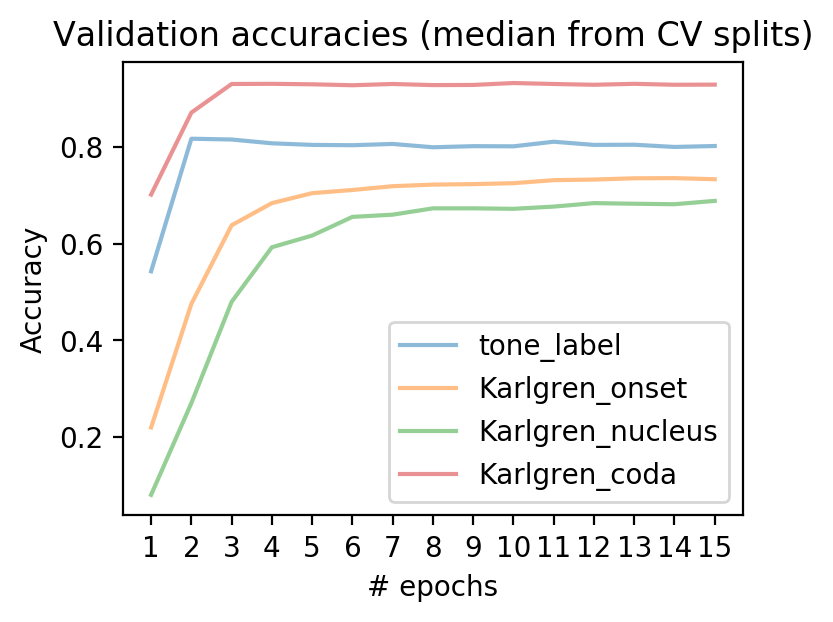

In [176]:
# MODE = 'median'
# # MODE = 'best'

# ax = plt.figure(figsize=(4,3), dpi=200)
# plt.title('Validation accuracies (' + MODE + ' from CV splits)')
# plt.xlabel('# epochs')
# plt.ylabel('Accuracy')
# xrange = range(1, N_EPOCHS + 1)
# plt.xticks(xrange, xrange)
# for category in label_categories:
#     if MODE == 'median':
#         run_idx = performance[category].index(sorted(performance[category])[len(performance[category]) // 2])
#     else:
#         run_idx = performance[category].index(max(performance[category]))
#     hist = callbacks[category][run_idx].history
#     plt.plot(xrange, hist['val_acc'], label=category, alpha=.5)
# plt.legend(loc='lower right')
# plt.show()
# ax.savefig('nn-cv-val-acc.png', format='png')

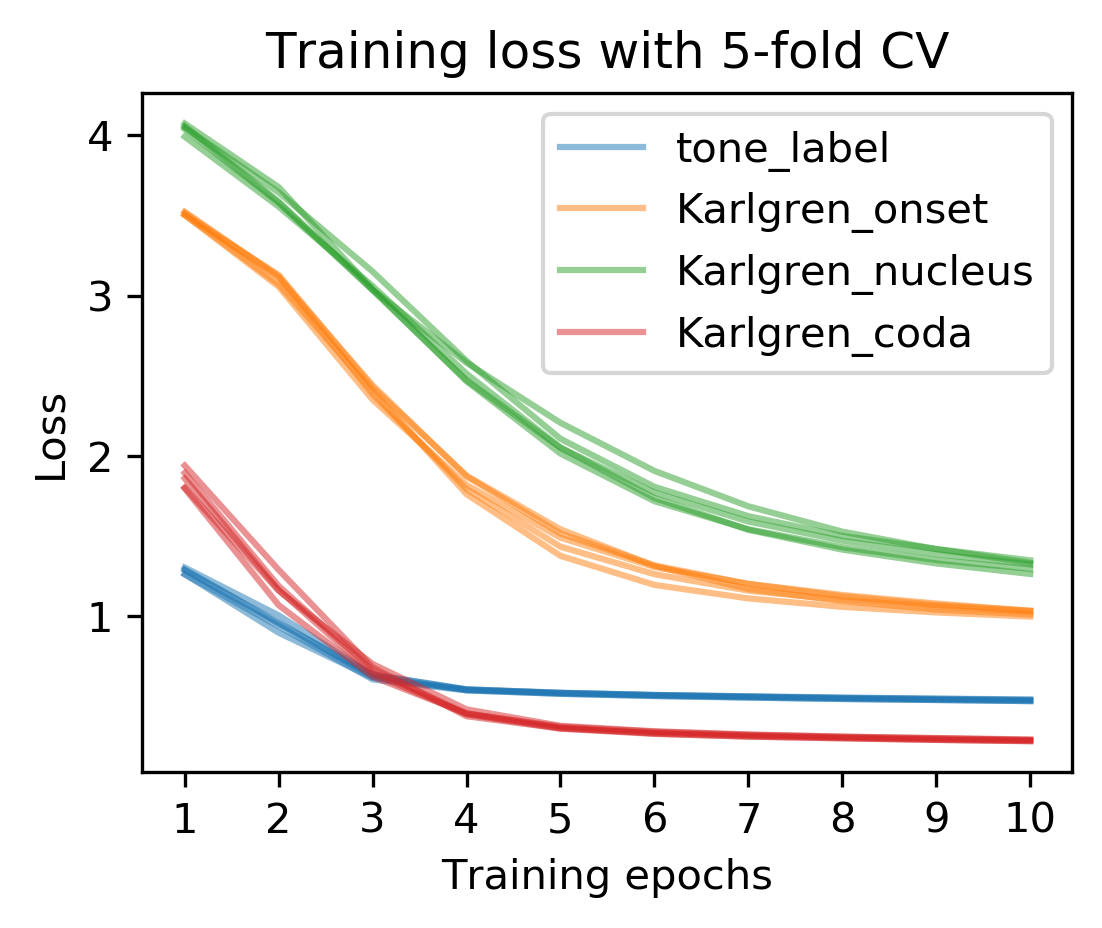

In [228]:
ax = plt.figure(figsize=(4,3), dpi=300)
plt.title('Training loss with 5-fold CV')
plt.xlabel('Training epochs')
plt.ylabel('Loss')
xrange = range(1, N_EPOCHS + 1 - 5)
plt.xticks(xrange, xrange)
for idx, category in enumerate(label_categories):
    for fold in range(N_FOLDS):
        val_acc = callbacks[category][fold].history['loss'][:-5]
        if not fold: 
            plt.plot(xrange, val_acc, label=category, color='C' + str(idx), alpha=.5)
        else:
            plt.plot(xrange, val_acc, label='__nolegend__', color='C' + str(idx), alpha=.5)
plt.legend()
# plt.tight_layout()
plt.show()
# ax.savefig('nn-cv-train-loss.eps', format='eps')

In [211]:
for cat in label_categories:
    best_idx = performance[cat].index(max(performance[cat]))
    print('{:16s}\t{:2.3f}%'.format(cat, 100 * test_performance[cat][best_idx]))

tone_label      	79.847%
Karlgren_onset  	70.645%
Karlgren_nucleus	65.355%
Karlgren_coda   	92.787%


In [193]:
test_performance

defaultdict(list,
            {'tone_label': [0.798251366602267,
              0.7962841519110841,
              0.7919125680975575,
              0.7984699449513127,
              0.7958469941316406],
             'Karlgren_onset': [0.6998907114508374,
              0.7086338797162791,
              0.7020765024195603,
              0.7071038237425799,
              0.7064480882524793],
             'Karlgren_nucleus': [0.6419672136880009,
              0.6513661190199722,
              0.6496174869120447,
              0.6535519122556259,
              0.6356284149878664],
             'Karlgren_coda': [0.9283060101863465,
              0.9278688537357935,
              0.9298360643881918,
              0.9276502745008208,
              0.9274316943799211]})

In [217]:
len(Y_complete[[x for x in Y_complete.columns if 'nucleus' in x]].columns)

62